In [1]:
%pylab inline 
from PIL import Image
from skimage.feature import corner_harris, corner_peaks
import numba
rcParams['figure.figsize'] = (12,9)

Populating the interactive namespace from numpy and matplotlib


In [8]:
img_u = Image.open('baby-yoda.jpg')
img_u = array(img_u.convert('L'))
img = img_u / 255

## Harris Corner Detection

### Example

- Compute corner response on grayscale image
- Threshold
- Apply non-maximum suppression

In [9]:
# @numba.njit()
def nms(vals, thresh, n=7):
    '''Non-maximum suppression'''
    n2 = n // 2
    out = zeros_like(vals)
    h, w = vals.shape
    for i in range(n2, h-n2):
        for j in range(n2, w-n2):
            if thresh[i, j]:
                if vals[i, j] == vals[i-n2:i+n2+1, j-n2:j+n2+1].max():
                    out[i,j] = 1
    return out

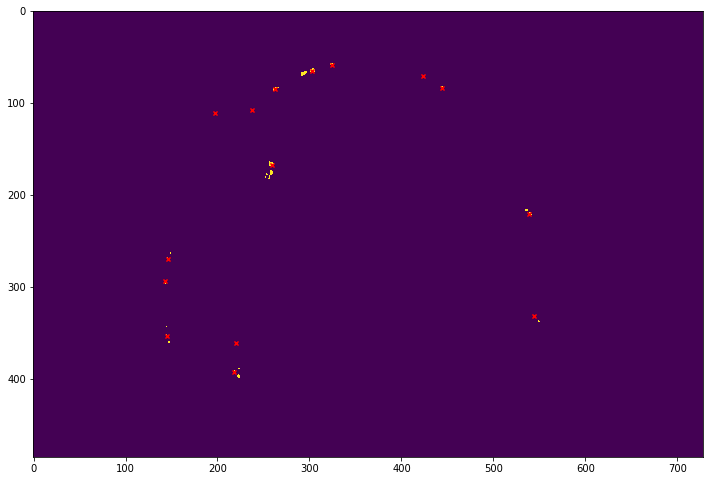

In [10]:
cornerness = corner_harris(img, k=.03)
thresh = cornerness > .5
nms_points = nms(cornerness, thresh, 21)
locs = nms_points.nonzero()
scatter(*(locs[::-1]), color='r', marker='x', s=17)
imshow(thresh)

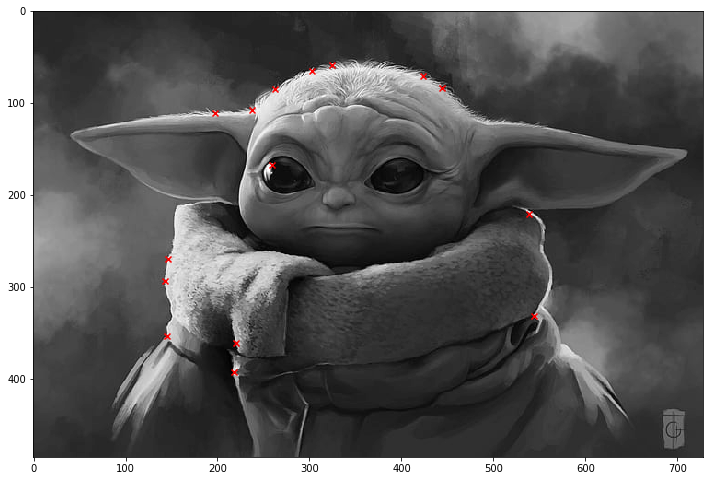

In [11]:
scatter(locs[1], locs[0], color='r', marker='x')
imshow(img, cmap='gray')

### Implementation

The structure tensor
$$\begin{bmatrix}\partial x\partial x & \partial x\partial y \\ \partial x\partial y & \partial y\partial y\end{bmatrix}$$
is a matrix of image derivatives (gradients) defined at each pixel, averaged over a neighborhood (to reduce noise). It has a similar form to a covariance matrix. The **eigenvectors** give us an orthogonal basis for the directions of highest variance, and the **eigenvalues** tell us how much variance there is along each of those directions. We're talking about variance in the gradient here. In other words, the eigenvalues give us an idea of how strong the gradient is in two different (orthogonal) directions.

A **corner** is a place in the image where the gradient is high in two approximately orthogonal directions. So we can use the eigenvalus to measure much each pixel is like a corner:
$$\frac{\lambda_1\lambda_2}{\lambda_1 + \lambda_2}$$
or
$$\lambda_1\lambda_2 - k(\lambda_1+\lambda_2)^2$$

But then remember (from linear algebra): the determinant of a matrix is equal to the product of its eigenvalues, and the trace of a matrix is equal to the sum of its eigenvalues. The determinant (for a $2\times2$ matrix at least) and trace are easy to calculate:
\begin{align}
\lambda_1\lambda_2&=\det(A)=a_{11}a_{22}-a_{12}a_{21}\\
\lambda_1+\lambda_2&=\text{trace}(A)=a_{11}+a_{22}
\end{align}

In [12]:
# Code adapted from scikit-image:
# https://github.com/scikit-image/scikit-image/blob/634ef74811520159c70a896f42242d3c9a5b95fc/skimage/feature/corner.py
import scipy.ndimage as ndi

def harris(image, k, sigma):
    imy = ndi.sobel(image, axis=0, mode=mode, cval=cval)
    imx = ndi.sobel(image, axis=1, mode=mode, cval=cval)
    
    Axx = ndi.gaussian_filter(imx * imx, sigma, mode=mode, cval=cval)
    Axy = ndi.gaussian_filter(imx * imy, sigma, mode=mode, cval=cval)
    Ayy = ndi.gaussian_filter(imy * imy, sigma, mode=mode, cval=cval)
    
    # determinant
    detA = Axx * Ayy - Axy ** 2
    # trace
    traceA = Axx + Ayy

    response = detA - k * traceA ** 2

    return response

## HOG -- Histogram of Oriented Gradients

In [13]:
from skimage.feature import hog
hog_res, hog_img = hog(array(Image.fromarray(img).resize((300, 240), Image.BICUBIC)), visualize=True)

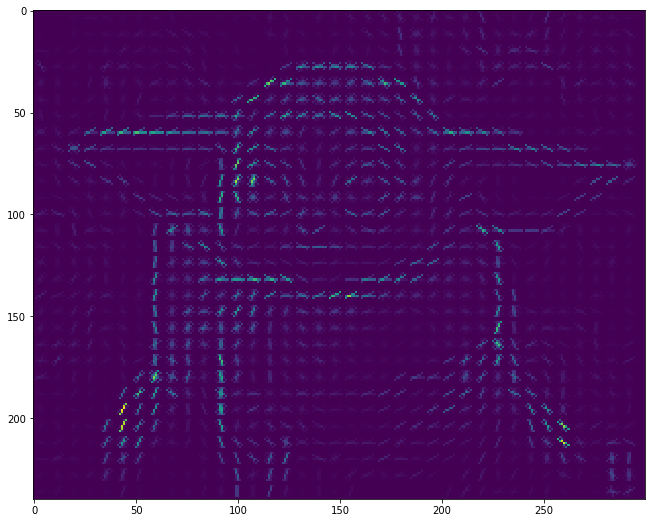

In [14]:
imshow(hog_img)

## Laplacian of Guassians and Difference of Gaussians (LoG and DoG)

The Laplacian of a Gaussian is the second derivative of the gaussian density function. Recall the definition of the gaussian (we will assume zero-mean):
$$g(x,\sigma)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{x^2}{2\sigma^2}}$$
and for a 2D, symmetric, independent signal
$$g(x,y,\sigma)=\frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$$
We can find the Laplacian by differentiating $g$ twice (ignoring the scaling factor for simplicity):
\begin{align}
\frac{\text{d}}{\text{d}x}g(x,\sigma) &= -\frac{x}{\sigma^2}e^{-\frac{x^2}{2\sigma^2}}\\
\frac{\text{d}^2}{\text{d}^2x}g(x,\sigma) &= \frac{x^2-\sigma^2}{\sigma^4}e^{-\frac{x^2}{2\sigma^2}}
\end{align}
If we find the 2nd partial for each dimension of our 2D signal and add them up, we get the Laplacian in two dimensions:
\begin{align}
\frac{\partial^2}{\partial^2x}g(x,y,\sigma) + \frac{\partial^2}{\partial^2y}g(x,y,\sigma) &= \frac{x^2+y^2-2\sigma^2}{\sigma^4}e^{-\frac{x^2+y^2}{2\sigma^2}}
\end{align}

The difference of two gaussians of different scales approximates the Laplacian of the gaussian:
\begin{align}
\frac{1}{\sigma_2-\sigma_1}(g(x,\sigma_2)-g(x,\sigma_1))\approx\frac{\partial^2}{\partial^2x}g(x,y,\sigma) + \frac{\partial^2}{\partial^2y}g(x,y,\sigma)
\end{align}

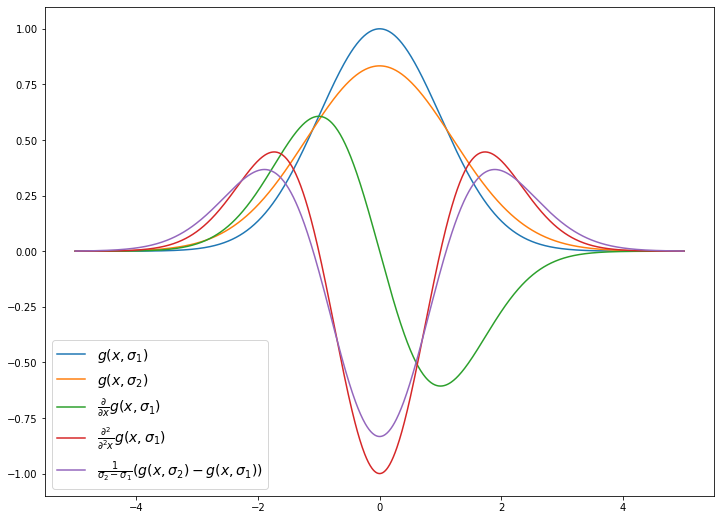

In [15]:
x = linspace(-5, 5, 1000)
sigma = 1
sigma2 = 1.2

gauss = exp(-.5*x**2/sigma**2) / sigma
gauss2 = exp(-.5*x**2/sigma2**2) / sigma2
dgauss = -x/sigma**2 * gauss
ddgauss = (x**2-sigma**2)/sigma**4 * gauss
difgauss = 1/(sigma2-sigma)*(gauss2 - gauss)

plot(x, gauss, label=r'$g(x, \sigma_1)$')
plot(x, gauss2, label=r'$g(x, \sigma_2)$')
plot(x, dgauss, label=r'$\frac{\partial}{\partial x}g(x,\sigma_1)$')
plot(x, ddgauss, label=r'$\frac{\partial^2}{\partial^2 x}g(x,\sigma_1)$')
plot(x,difgauss, label=r'$\frac{1}{\sigma_2-\sigma_1}(g(x, \sigma_2) - g(x, \sigma_1))$')
legend(fontsize=14)
pass

Text(0.5, 1.0, '$\\frac{\\partial^2}{\\partial^2 x}g(x)$')

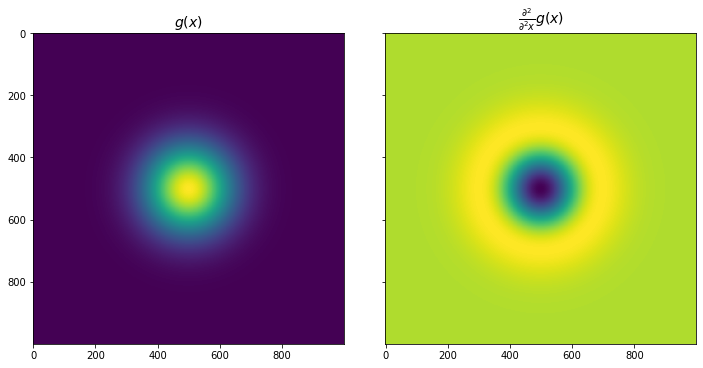

In [16]:
x, y = mgrid[-500:500, -500:500]
x, y = x/100, y/100
gauss = exp(-.5*(x**2+y**2)/sigma**2)
ddgauss = 1/sigma**4*(x**2+y**2-2*sigma**2)*gauss

fig, ax = subplots(1, 2, figsize=(10,5), constrained_layout=True, sharey=True)
ax[0].imshow(gauss)
ax[0].set_title(r'$g(x)$', fontsize=14)
ax[1].imshow(ddgauss)
ax[1].set_title(r'$\frac{\partial^2}{\partial^2 x}g(x)$', fontsize=14)
# contourf(x, y, gauss, 50)
# gca().set_aspect(1)

## Scale Space

Create a set of gaussian blurred images of different scales (standard deviations). Take their differences to approximate the Laplacian at different scales. This creates a *scale space*.

In [17]:
from skimage.filters import gaussian
sigmas = [sqrt(2)**i for i in range(5)]
blurs = [gaussian(img, s) for s in sigmas]

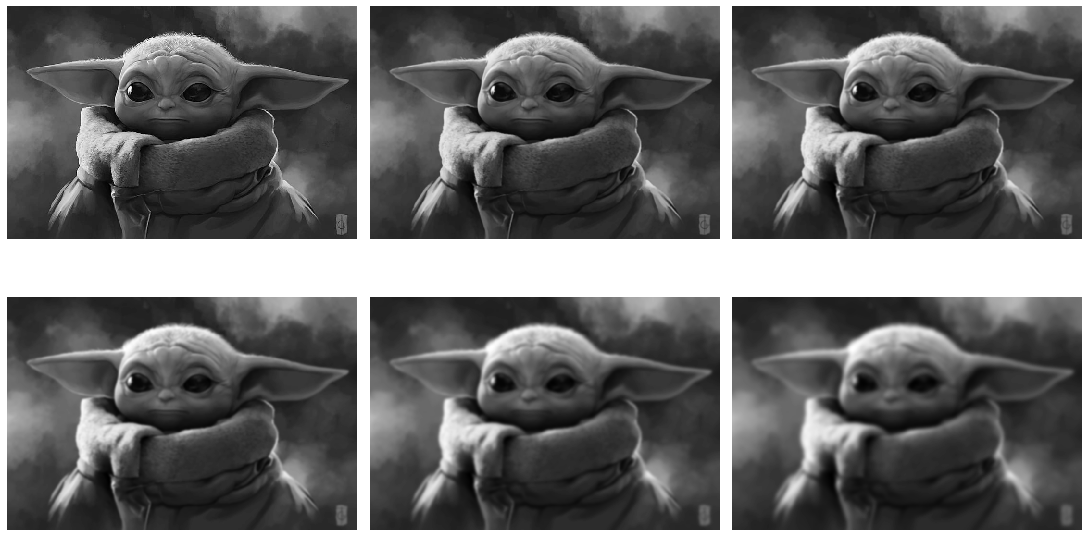

In [18]:
fig, ax = subplots(2, 3, figsize=(15, 8), constrained_layout=True, sharex=True, sharey=True)
ax = ax.flatten()
for a in ax: a.axis('off')
ax[0].imshow(img, cmap='gray')
for i in range(5):
    ax[i+1].imshow(blurs[i], cmap='gray')

Compute the "Difference of Gaussians" scale space by subtracting adjacent scales (blurred images)

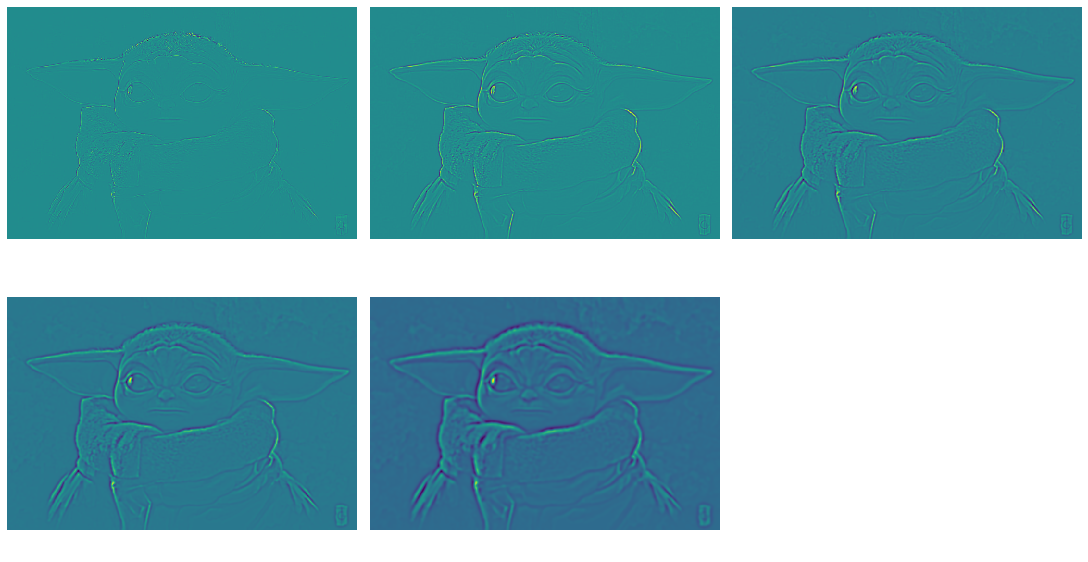

In [19]:
dogs = [img] + blurs
dogs = [dogs[i] - dogs[i+1] for i in range(len(dogs)-1)]
dogs = stack(dogs, 2)

fig, ax = subplots(2, 3, figsize=(15, 8), constrained_layout=True, sharex=True, sharey=True)
ax = ax.flatten()
for a in ax: a.axis('off')
for i in range(5):
    ax[i].imshow(dogs[...,i])

Extrema in the scale space identify features of the corresponding scales.

In [20]:
@numba.njit()
def find_extrema(dogs):
    out = []
    inds = array([(i,j,k) for i in range(3) 
                          for j in range(3) 
                          for k in range(3) 
                          if not (i == 1 and j == 1 and k == 1)]) - 1
    for r in range(1, dogs.shape[0]-1):
        for c in range(1, dogs.shape[1]-1):
            for s in range(1, dogs.shape[2]-1):
                mn = True
                mx = True
                v = dogs[r,c,s]
                for a in range(len(inds)):
                    i, j, k = inds[a, 0], inds[a, 1], inds[a, 2]
                    if dogs[r+i,c+j,s+k] < v: mn = False
                    if dogs[r+i,c+j,s+k] > v: mx = False
                    if not (mx or mn):
                        break
                if mx or mn:
                    out.append([r,c,s-1])
    return np.array(out)

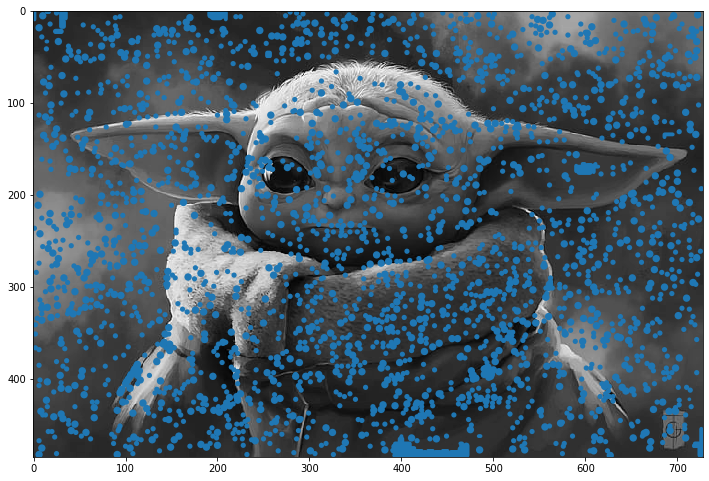

In [21]:
extr = find_extrema(dogs)
# scatter(extr[:,1], extr[:,0], marker='x', color='r')
imshow(img, cmap='gray')
for p in extr:
    gca().add_artist(Circle((p[1],p[0]), sigmas[p[2]+1]*1.414))

## SIFT -- Scale Invariant Feature Transform

In [23]:
from cv2 import drawKeypoints
from cv2 import xfeatures2d as xft

In [24]:
sift = xft.SIFT_create(750)
kps, descs = sift.detectAndCompute((img*255).astype(uint8), None)

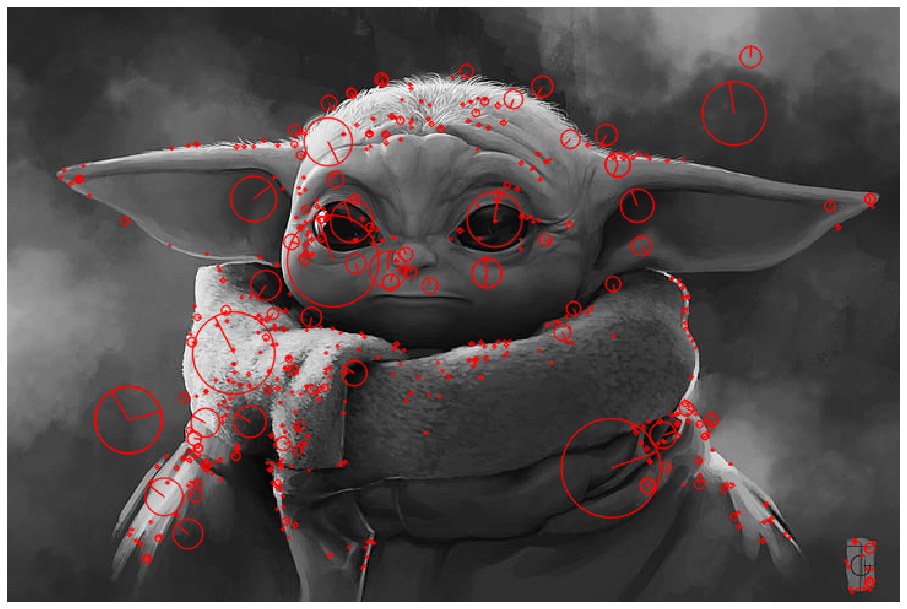

In [25]:
figure(figsize=(16,14))
gca().axis('off')
imshow(drawKeypoints(img_u, kps, None, (255,0,0), flags=4))